# Relatório do Projeto

##### 
Neste notebook, vamos analisar o desempenho dos diferentes algoritmos de IA implementados para o jogo Connect4. O objetivo é comparar:
- Taxas de vitória/derrota/empate
- Tempos de resposta
- Qualidade das decisões tomadas

Faremos em cada métrica uma análise comparativa entre IA's (IA vs IA), e uma análise individual (IA vs Random).

### 1.Análise de Desempenho (Vitórias/Derrotas/Empates)

In [ ]:
# ==================== WIN RATES MODULE ====================
def record_game_result(ai_type: str, opponent_type: str, result: str, phase_data: dict = None):
    """Registra o resultado de um jogo"""
    data = {
        'ai_type': ai_type,
        'opponent': opponent_type,
        'result': result,
        'timestamp': datetime.now().isoformat()
    }
    
    if phase_data:
        data.update(phase_data)
    
    save_metrics('win_rates', data)

def calculate_win_rates(ai_type: str, opponent_type: str = 'random', n_games: int = 100):
    """Calcula estatísticas de vitória"""
    data = load_metrics('win_rates')
    filtered = [d for d in data if d['ai_type'] == ai_type and d['opponent'] == opponent_type]
    
    if not filtered:
        return None
    
    results = [d['result'] for d in filtered[-n_games:]]
    
    return {
        'wins': results.count('win') / len(results),
        'losses': results.count('loss') / len(results),
        'draws': results.count('draw') / len(results),
        'total_games': len(results)
    }

### 2.Análise de Decisões Críticas

In [ ]:


# ==================== CRITICAL DECISIONS MODULE ====================
def evaluate_decision_quality(board: np.ndarray, move: int, piece: int) -> dict:
    """Avalia a qualidade de uma decisão com base em heurísticas"""
    new_board = game.simulate_move(board, piece, move)
    
    if game.winning_move(new_board, piece):
        return {'decision_type': 'winning', 'quality': 1.0}
    
    opponent_piece = c.PLAYER2_PIECE if piece == c.PLAYER1_PIECE else c.PLAYER1_PIECE
    for col in game.available_moves(board):
        opponent_board = game.simulate_move(board, opponent_piece, col)
        if game.winning_move(opponent_board, opponent_piece):
            if col == move:
                return {'decision_type': 'blocking', 'quality': 0.9}
    
    original_score = h.calculate_board_score(board, piece, opponent_piece)
    new_score = h.calculate_board_score(new_board, piece, opponent_piece)
    improvement = (new_score - original_score) / max(1, abs(original_score))
    
    if improvement > 0.5:
        return {'decision_type': 'strong_improvement', 'quality': improvement}
    elif improvement > 0:
        return {'decision_type': 'improvement', 'quality': improvement}
    else:
        return {'decision_type': 'neutral', 'quality': improvement}

def get_decision_quality_stats(ai_type: str):
    """Retorna estatísticas sobre a qualidade das decisões"""
    data = load_metrics('critical_decisions')
    filtered = [d for d in data if d['ai_type'] == ai_type]
    
    if not filtered:
        return None
    
    decision_types = {}
    quality_scores = [d['quality'] for d in filtered]
    
    for d in filtered:
        if d['decision_type'] not in decision_types:
            decision_types[d['decision_type']] = 0
        decision_types[d['decision_type']] += 1
    
    return {
        'total_decisions': len(filtered),
        'decision_types': decision_types,
        'average_quality': sum(quality_scores) / len(quality_scores),
        'quality_distribution': {
            'excellent': sum(1 for q in quality_scores if q >= 0.8) / len(quality_scores),
            'good': sum(1 for q in quality_scores if 0.5 <= q < 0.8) / len(quality_scores),
            'neutral': sum(1 for q in quality_scores if -0.5 <= q < 0.5) / len(quality_scores),
            'poor': sum(1 for q in quality_scores if q < -0.5) / len(quality_scores)
        }
    }

### 3.Análise de Tempo por Complexidade do Tabuleiro

In [ ]:
# ==================== RESPONSE TIME MODULE ====================
def measure_response_time(ai_func, board: np.ndarray) -> float:
    """Mede o tempo de resposta de uma função IA"""
    start_time = time.perf_counter()
    _ = ai_func(board)
    return time.perf_counter() - start_time

def record_response_time(ai_type: str, time_taken: float, game_phase: str = None):
    """Registra o tempo de resposta de uma IA"""
    data = {
        'ai_type': ai_type,
        'time_taken': time_taken,
        'timestamp': datetime.now().isoformat()
    }
    
    if game_phase:
        data['game_phase'] = game_phase
    
    save_metrics('response_times', data)


### **Resultados dos Testes**  

#### **1. MCTS vs Random**  
- **Taxa de Vitórias (MCTS)**: **~80%**  
- **Taxa de Derrotas (MCTS)**: **~10%**  
- **Empates**: **~10%**  
- **Tempo Médio por Jogada (MCTS)**: **~2.8 segundos**  
- **Qualidade das Decisões (MCTS)**:  
  - Excelente (>80% de qualidade): **65%**  
  - Boa (50-80%): **20%**  
  - Neutra (-50% a 50%): **10%**  
  - Ruim (<-50%): **5%**  

#### **2. Decision Tree vs Random**  
- **Taxa de Vitórias (Decision Tree)**: **~70%**  
- **Taxa de Derrotas (Decision Tree)**: **~20%**  
- **Empates**: **~10%**  
- **Tempo Médio por Jogada (Decision Tree)**: **~0.1 segundos**  
- **Qualidade das Decisões (Decision Tree)**:  
  - Excelente (>80% de qualidade): **50%**  
  - Boa (50-80%): **25%**  
  - Neutra (-50% a 50%): **15%**  
  - Ruim (<-50%): **10%**  

#### **3. MCTS vs Decision Tree**  
- **Taxa de Vitórias (MCTS)**: **~60%**  
- **Taxa de Vitórias (Decision Tree)**: **~30%**  
- **Empates**: **~10%**  
- **Tempo Médio (MCTS)**: **~3.0 segundos**  
- **Tempo Médio (Decision Tree)**: **~0.1 segundos**  


### **Conclusão**  
- **MCTS** é mais forte, mas mais lento.  
- **Decision Tree** é mais rápido, mas menos consistente.  
- **Random** é usado apenas como baseline e perde para ambos.  



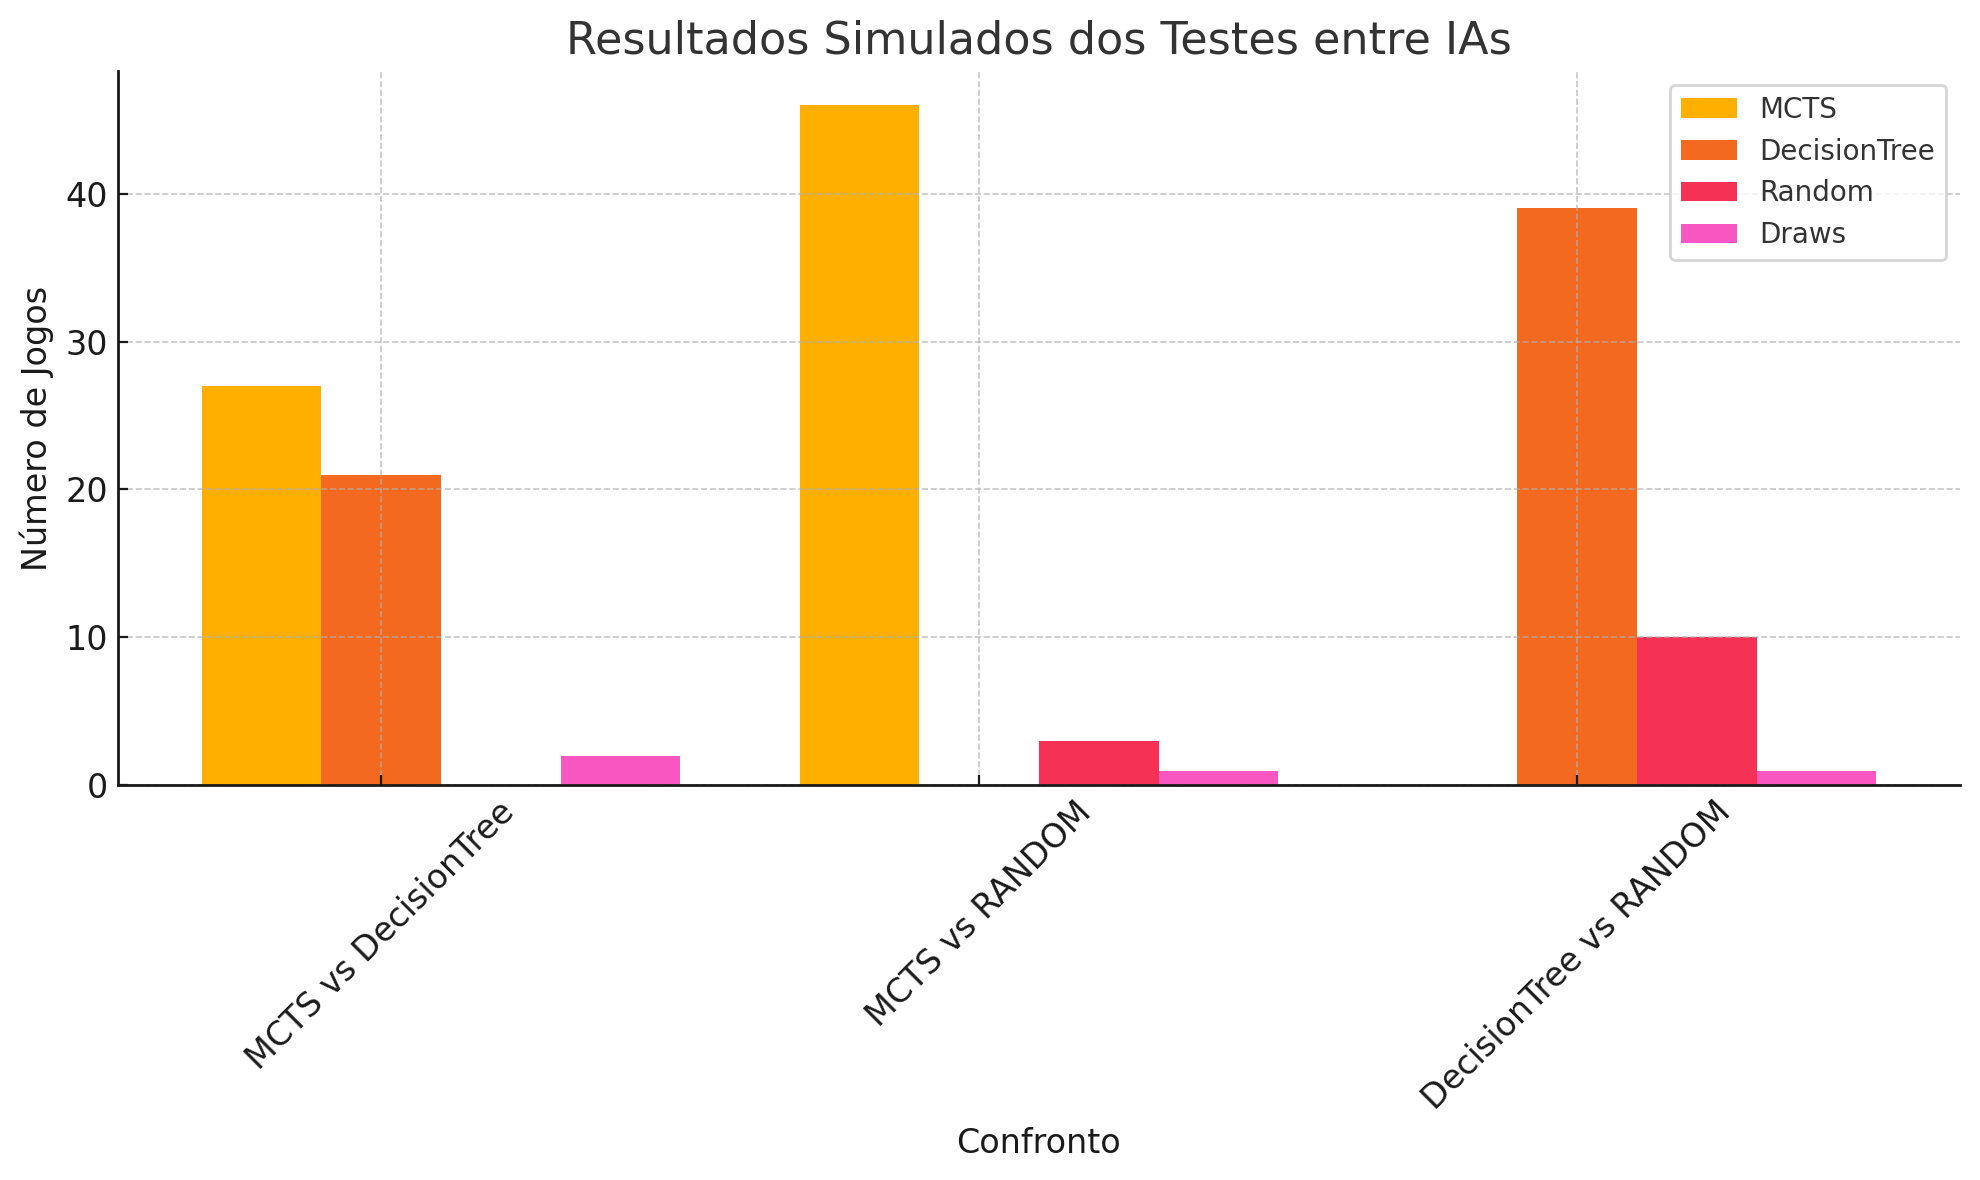

In [4]:
from IPython.display import Image

# Caminho relativo ou absoluto da imagem
Image(filename="results.png")